In [106]:
import pandas as pd
import numpy as np
import os
import sys
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import json
from datetime import datetime
import random

Using data from GZD-5.

In [76]:
# General path to data and other files needed
path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/'

In [77]:
df = pd.read_csv(path + 'gz_decals_volunteers_5.csv')

# Filter out rows with too few votes to ensure reliability
#df = df[df['smooth-or-featured_total-votes'] > 5]

# Selecting the relevant columns (at least for now)
label_cols = [
    'smooth-or-featured_smooth_debiased',
    'smooth-or-featured_featured-or-disk_debiased',
    'smooth-or-featured_artifact_debiased',
    'disk-edge-on_yes_debiased',
    'disk-edge-on_no_debiased',
    'bar_strong_debiased',
    'bar_weak_debiased',
    'bar_no_debiased'
]

df_labels = df[['iauname', 'png_loc'] + label_cols].copy()          # Copying the relevant columns to a new DataFrame including the image name and location

# Cleaning the data, i.e., removing NaN values in the label columns - this ensures that we only keep rows with valid labels and can therefore actually use the data for training
df_clean = df_labels.dropna(subset = label_cols).reset_index(drop = True)

# Inspecting the first few rows of the DataFrame
#print(df_clean.head())

In [78]:
# Getting the image data 
path_images = path + 'gz_decals_dr5_png_part1'

""" The folder contains more folders, each with a set of images. The names of the images correspond to the 'iauname' in the DataFrame. """

# Step 1: Recursively collect all image file paths
all_image_paths = glob(os.path.join(path_images, '**', '*.png'), recursive = True)

# Step 2: Create a lookup dict: iauname -> full path
# Assumes filenames are like 'J123456.78+123456.7.png'
iauname_to_path = {
    os.path.splitext(os.path.basename(png_path))[0]: png_path
    for png_path in all_image_paths
}

# Step 3: Create a new column in your clean DataFrame with the full path
df_clean['full_image_path'] = df_clean['iauname'].map(iauname_to_path)

# Step 4: Drop any rows where the image file wasn't found
df_clean = df_clean.dropna(subset = ['full_image_path']).reset_index(drop = True)

# Inspecting the DataFrame after adding the image paths
#print(df_clean.head())

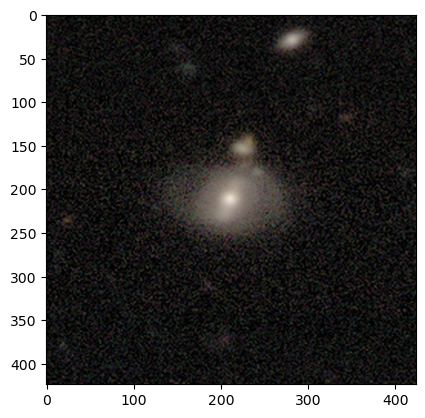

In [79]:
# Plotting one image to test if we can load it correctly

first_image_path = df_clean['full_image_path'].iloc[0]
image = Image.open(first_image_path)
plt.imshow(image)

Loading and plotting the images work - so far so good! Data seems to be ready. 

In [80]:
# Now we create a PyTorch Dataset class to handle the images and labels

# class GalaxyDataset(Dataset):
#     def __init__(self, df, label_cols, transform = None):
#         self.df = df                                                                # DataFrame containing the image paths and labels
#         self.label_cols = label_cols                                                # List of label columns to be used
#         self.transform = transform or transforms.Compose([                          # Default transformations if none are provided
#             transforms.Resize((224, 224)),                                                  # Resize images to a fixed size
#             transforms.ToTensor(),                                                          # Convert PIL images to PyTorch tensors
#             transforms.Normalize([0.5], [0.5])                                              # Normalize with ImageNet stats assuming grayscale images or RGB images
#         ])

#     def __len__(self):
#         return len(self.df)                                                          # Returns the number of samples in the dataset
    
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]                                                      # Get the row at the specified index
#         image = Image.open(row['full_image_path']).convert('RGB')                    # Open the image using PIL and convert it to RGB format
#         if self.transform:
#             image = self.transform(image)                                            # Apply transformations to the image

#         label = torch.tensor(row[self.label_cols].astype(float).values, dtype = torch.float32)     # Convert the labels to a PyTorch tensor

#         return image, label                                                          # Return the image and its corresponding labels as a tuple

In [81]:
# Splitting the dataset into training, validation, and test sets
df_train, df_val = train_test_split(df_clean, test_size = 0.2, random_state = 42)
def_val, df_test = train_test_split(df_val, test_size = 0.5, random_state = 42)

In [82]:
# Creating DataLoaders for each set
sys.path.append("/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla")

from galaxy_dataset import GalaxyDataset

train_dataset = GalaxyDataset(df_train, label_cols)
val_dataset = GalaxyDataset(df_val, label_cols)

""" A DataLoader is used to load the dataset in batches, which is useful for training models in PyTorch. The DataLoader will handle shuffling and parallel loading of the data. """

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 9)                  
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 9)

Now we are ready to build a model. We start with a basic convolutional neural network (CNN) in PyTorch for multi-label classification of the galaxy morphology based on the image input. We have the following: 
- Input size: 224x224 RBG images
- Output: Multi-label

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [84]:
# Defining a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_outputs = 8):                                        # Initialize the CNN with a specified number of output classes (default is 8)

        super(SimpleCNN, self).__init__()                                       # Initialize the parent class 

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)             # First convolutional layer with 3 input channels (RGB), 16 output channels, and a kernel size of 3
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)            # Second convolutional layer with 16 input channels and 32 output channels
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)            # Third convolutional layer with 32 input channels and 64 output channels

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)                   # Max pooling layer to reduce spatial dimensions 
        self.dropout = nn.Dropout(0.5)                                          # Dropout layer to prevent overfitting - randomly sets 50% of the input units to 0 during training

        self.fc1 = nn.Linear(64 * 28 * 28, 256)                                 # Fully connected layer with input size based on the output of the last convolutional layer and 256 output units
        self.fc2 = nn.Linear(256, num_outputs)                                  # Second fully connected layer with 256 input units and output size equal to the number of labels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                                    # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))                                    # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv3(x)))                                    # Apply third convolution, ReLU activation, and max pooling

        x = x.view(x.size(0), -1)                                                # Flatten the tensor for the fully connected layers
        x = F.relu(self.fc1(x))                                                  # Apply first fully connected layer with ReLU activation
        x = self.dropout(x)                                                      # Apply dropout
        x = self.fc2(x)                                                          # Apply second fully connected layer

        return x                                                                 # Return the output logits

Ready for training! We will use PyTorch Lightning.

In [85]:
import lightning as L
from lightning.pytorch import Trainer

In [86]:
# Wrapping the model in a PyTorch Lightning module
class LitGalaxyModel(L.LightningModule):
    def __init__(self, model, criterion, learning_rate = 0.001):
        super().__init__()
        self.model = model                                                  # The CNN model                   
        self.criterion = criterion                                          # The loss function               
        self.save_hyperparameters(ignore = ['model', 'criterion'])          # Save hyperparameters except the model and criterion itself

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss, prog_bar = True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr = self.hparams.learning_rate)

In [87]:
# Creating the model, loss function, and PyTorch Lightning module
lit_model = LitGalaxyModel(model = SimpleCNN(num_outputs = len(label_cols)),
                           criterion = nn.BCEWithLogitsLoss(),  # Binary Cross-Entropy Loss for multi-label classification
                           learning_rate = 0.001)

In [88]:
# Check if MPS is available (Apple Silicon GPU)
if torch.backends.mps.is_available():
    accelerator = 'mps'
elif torch.cuda.is_available():
    accelerator = 'gpu'
else:
    accelerator = 'cpu'

# Creating the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs = 10,                                                        # Set the number of epochs for training
    accelerator = 'gpu' if torch.cuda.is_available() else 'cpu',            # Use GPU if available
    enable_progress_bar = True,  # Enable progress bar
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [89]:
# Training the model
trainer.fit(
    model = lit_model,
    train_dataloaders = train_loader,
    val_dataloaders = val_loader
)

"""
NOTE TO SELF:
Epoch 0 is a warm-up epoch, so the first training step is not counted in the progress bar. The training loss is logged, but the validation loss is not logged until the first epoch is completed. 
The epoch is a sanity check to ensure that the model can run through one full pass of the training data without errors.
"""


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | SimpleCNN         | 12.9 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.484    Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [97]:
# Evaluatinf the model on the validation set
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(model.device)
            labels = labels.to(model.device).int()                                                                  # Ensure labels are in integer format for multi-label classification        

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).int()                                                            # Apply sigmoid activation and threshold at 0.5 to get binary predictions for each label independently

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return {
        # The zero_division parameter is set to 0 to avoid errors when there are no positive predictions
        'accuracy': accuracy_score(all_labels, all_preds),                                                          # Calculate accuracy
        'precision_macro': precision_score(all_labels, all_preds, average = 'macro', zero_division = 0),            # Calculate macro-averaged precision - average precision across all labels, treating each label equally
        'recall_macro': recall_score(all_labels, all_preds, average = 'macro', zero_division = 0),                  # Calculate macro-averaged recall - measures how well the model detects each label, regardless of frequency (high recall means fewer false positives)
        'f1_macro': f1_score(all_labels, all_preds, average = 'macro', zero_division = 0),                          # Calculate macro-averaged F1 score - combines precision and recall into a single metric, balancing both and thus gives a view of how well each label is predicted
        'f1_micro': f1_score(all_labels, all_preds, average = 'micro', zero_division = 0),                          # Calculate micro-averaged F1 score - computes global counts of true positives, false positives, and false negatives across all labels => tells how well the model performs ovarall, favoring frequent labels more
    }

In [99]:
metrics = evaluate_model(lit_model, val_loader)

In [102]:
print("🔍 Validation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

🔍 Validation Metrics:
accuracy: 0.0354
precision_macro: 0.1511
recall_macro: 0.4846
f1_macro: 0.2138
f1_micro: 0.4344


<center>
<table>
  <thead>
    <tr>
      <th>Metric</th>
      <th>Value</th>
      <th>Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Accuracy</strong></td>
      <td>0.0354</td>
      <td>Very low — not meaningful in multi-label context; requires exact match on all labels.</td>
    </tr>
    <tr>
      <td><strong>Macro Precision</strong></td>
      <td>0.1511</td>
      <td>Low — the model often predicts labels that aren’t actually there (many false positives).</td>
    </tr>
    <tr>
      <td><strong>Macro Recall</strong></td>
      <td>0.4846</td>
      <td>Moderate — the model catches many true labels, even if it guesses too much.</td>
    </tr>
    <tr>
      <td><strong>Macro F1</strong></td>
      <td>0.2138</td>
      <td>Overall poor per-label performance; likely due to imbalance and overprediction.</td>
    </tr>
    <tr>
      <td><strong>Micro F1</strong></td>
      <td>0.4344</td>
      <td>Moderate — better on frequent labels; shows overall the model is learning something.</td>
    </tr>
  </tbody>
</table>
</center>

In [103]:
# Saving the model
model_save_path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models'

In [104]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model checkpoint
model_path = os.path.join(model_save_path, f"lit_galaxy_model_{timestamp}.ckpt")
trainer.save_checkpoint(model_path)
print(f"✅ Model saved to: {model_path}")

# Save evaluation metrics
metrics_path = os.path.join(model_save_path, f"metrics_{timestamp}.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)
print(f"✅ Metrics saved to: {metrics_path}")

✅ Model saved to: /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models/lit_galaxy_model_20250602_112712.ckpt
✅ Metrics saved to: /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models/metrics_20250602_112712.json


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].


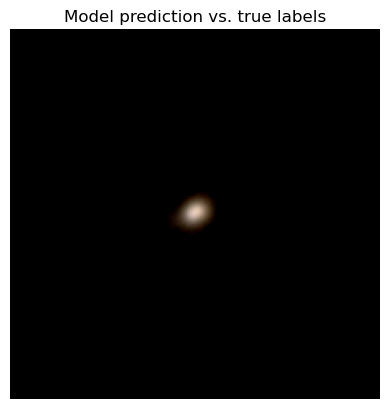

Predicted labels:
✅ smooth-or-featured_featured-or-disk_debiased
✅ disk-edge-on_no_debiased
✅ bar_no_debiased

True labels:
🔷 disk-edge-on_no_debiased
🔷 bar_no_debiased


In [116]:
# Picking an example from the validation set to visualize predictions
idx = 20
image, true_labels = val_dataset[idx]

# Move image to batch form and same device as model
image_batch = image.unsqueeze(0).to(lit_model.device)

# Get predictions
lit_model.eval()
with torch.no_grad():
    output = lit_model(image_batch)
    probs = torch.sigmoid(output).squeeze(0).cpu().numpy()
    pred_labels = (probs >= 0.5).astype(int)

# Plot the image
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  # Convert from CxHxW to HxWxC
plt.axis('off')
plt.title("Model prediction vs. true labels")
plt.show()

# Display predicted and true labels
print("Predicted labels:")
for label, value in zip(label_cols, pred_labels):
    if value == 1:
        print(f"✅ {label}")

print("\nTrue labels:")
for label, value in zip(label_cols, true_labels.numpy().astype(int)):
    if value == 1:
        print(f"🔷 {label}")


<b>Comment</b>: The model correctly predicts one of the labels, but also predict one extra label that isn't present in the ground truth - i.e., a false positive. It is a reasonable good prediction. 

In [117]:
def visualize_predictions(model, dataset, label_cols, num_samples=6):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    rows = (num_samples + 2) // 3
    plt.figure(figsize=(15, 5 * rows))

    for i, idx in enumerate(indices):
        image, true_labels = dataset[idx]
        image_batch = image.unsqueeze(0).to(model.device)

        with torch.no_grad():
            outputs = model(image_batch)
            probs = torch.sigmoid(outputs).squeeze(0).cpu().numpy()
            pred_labels = (probs >= 0.5).astype(int)                                    # Apply sigmoid activation and threshold at 0.5 to get binary predictions for each label independently - the threshold can be adjusted based on the problem and the distribution of labels

        true_labels = true_labels.numpy().astype(int)

        # Predicted and true labels as lists
        predicted = [f"- {label}" for label, val in zip(label_cols, pred_labels) if val == 1]
        actual = [f"- {label}" for label, val in zip(label_cols, true_labels) if val == 1]

        pred_str = "\n".join(predicted) if predicted else "None"
        true_str = "\n".join(actual) if actual else "None"

        # Plotting
        ax = plt.subplot(rows, 3, i + 1)
        img_np = np.transpose(image.numpy(), (1, 2, 0))
        ax.imshow(img_np)
        ax.axis("off")

        # Display labels below image
        ax_text = f"Predicted:\n{pred_str}\n\nTrue:\n{true_str}"
        ax.set_title(ax_text, fontsize=10, loc='left')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.20784318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].


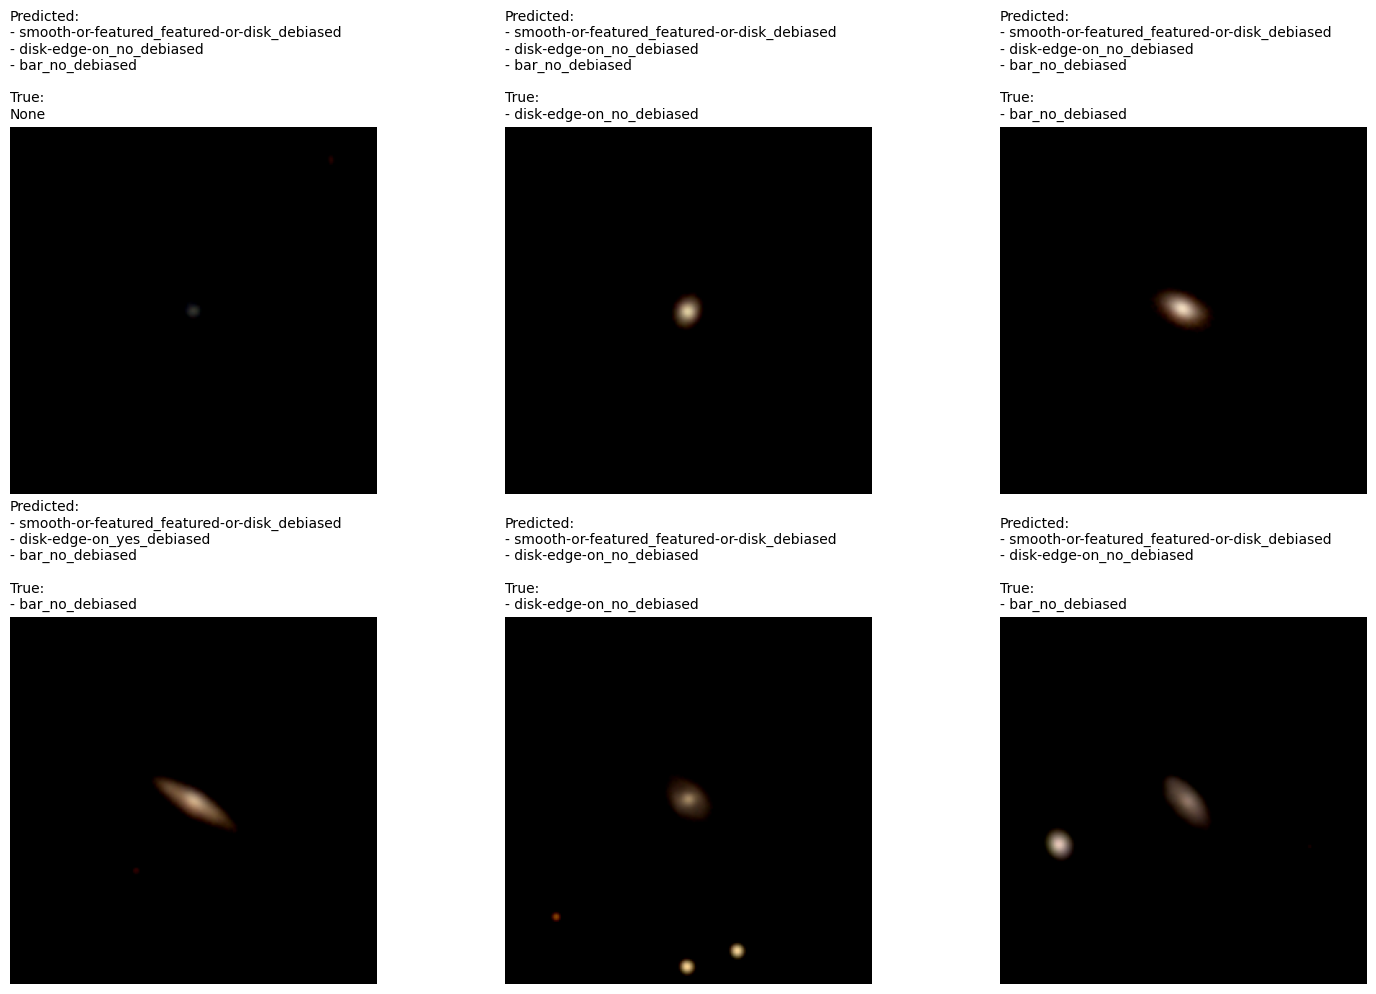

In [119]:
visualize_predictions(lit_model, val_dataset, label_cols);